In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
(X_train,Y_train),(X_test,Y_test) = keras.datasets.reuters.load_data()

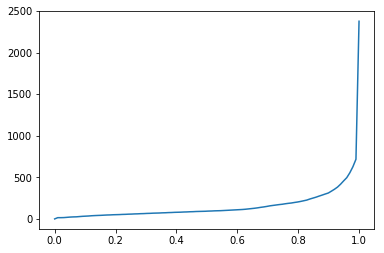

In [3]:
data_input_len_quantile_x = np.linspace(0, 1, num=100)
data_input_len_quantile_y = np.quantile(
    [len(x) for x in X_train] + [len(x) for x in X_test], data_input_len_quantile_x)
plt.plot(data_input_len_quantile_x, data_input_len_quantile_y)
plt.show()

In [4]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=64, padding='post', truncating='post')
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=64, padding='post', truncating='post')
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((8982, 64), (8982,), (2246, 64), (2246,))

In [5]:
data_input_dim = max(np.max(X_train), np.max(X_test)) + 1
data_input_dim

30979

In [6]:
data_output_dim = max(np.max(Y_train), np.max(Y_test)) + 1
data_output_dim

46

In [7]:
class DNCCell(keras.layers.Layer):
    
    def __init__(self,
                 output_size,
                 word_size,
                 memory_size,
                 register_size=2,
                 read_head_count=3,
                 enable_temporal=True,
                 enable_final_bias=True,
                 bypass_dropout_factor=None,
                 **kwargs):
        self.output_size = output_size
        self.word_size = word_size
        self.memory_size = memory_size
        self.register_size = register_size
        self.read_head_count = read_head_count
        self.enable_temporal = enable_temporal
        self.enable_final_bias = enable_final_bias
        self.bypass_dropout_factor = bypass_dropout_factor
        self.state_size = (output_size,)
        self.state_size += (register_size * word_size,)
        self.state_size += (register_size * word_size,)
        self.state_size += (memory_size * word_size,)
        self.state_size += (read_head_count * memory_size,)
        self.state_size += (read_head_count * word_size,)
        self.state_size += (memory_size,)
        self.state_size += (memory_size,)
        if enable_temporal:
            self.state_size += (memory_size,)
            self.state_size += (memory_size * memory_size,)
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        read_vec_size = self.word_size * self.read_head_count
        controller_input_size = input_shape[-1]
        controller_input_size += read_vec_size
        controller_input_size += self.register_size*self.word_size
        controller_kernel_size = self.register_size*self.word_size*4
        controller_hidden_size = self.register_size*self.word_size
        interface_vec_size = read_vec_size
        interface_vec_size += self.word_size * 3
        interface_vec_size += self.read_head_count * 2
        if self.enable_temporal:
            interface_vec_size += self.read_head_count * 3
        interface_vec_size += 3
        self.kernel_controller_hidden = self.add_weight(
            shape=(controller_input_size, controller_kernel_size),
            initializer='glorot_normal', name='kernel_controller_hidden')
        self.bias_controller_hidden = self.add_weight(
            shape=(controller_kernel_size,),
            initializer='zeros', name='bias_controller_hidden')
        self.kernel_controller_output = self.add_weight(
            shape=(controller_hidden_size, self.output_size + interface_vec_size),
            initializer='glorot_normal', name='kernel_controller_output')
        self.kernel_read_vec_to_output = self.add_weight(
            shape=(read_vec_size, self.output_size),
            initializer='glorot_normal', name='kernel_read_vec_to_output')
        if self.enable_final_bias:
            self.bias_final_output = self.add_weight(
                shape=(self.output_size,),
                initializer='zeros', name='bias_final_output')
        super().build(input_shape)
    
    def call(self, inputs, states):
        
        def oneplus(x):
            return K.softplus(x) + 1.
        
        def similarity(m, k, b):
            dot = K.batch_dot(k, m, axes=2)
            m_len = K.sqrt(K.sum(K.square(m), axis=-1))
            k_len = K.sqrt(K.sum(K.square(k), axis=-1))
            mk_len = K.expand_dims(k_len, axis=-1) @ K.expand_dims(m_len, axis=-2)
            mk_len = K.switch(K.not_equal(mk_len, 0.), mk_len, K.ones_like(mk_len))
            cos_sim = dot / mk_len
            return K.softmax(cos_sim * K.expand_dims(b))
        
        def batch_invert_permutation(permutations):
            # from https://github.com/deepmind/dnc/blob/master/dnc/util.py
            perm = tf.cast(permutations, tf.float32)
            dim = int(perm.get_shape()[-1])
            size = tf.cast(tf.shape(perm)[0], tf.float32)
            delta = tf.cast(tf.shape(perm)[-1], tf.float32)
            rg = tf.range(0, size * delta, delta, dtype=tf.float32)
            rg = tf.expand_dims(rg, 1)
            rg = tf.tile(rg, [1, dim])
            perm = tf.add(perm, rg)
            flat = tf.reshape(perm, [-1])
            perm = tf.invert_permutation(tf.cast(flat, tf.int32))
            perm = tf.reshape(perm, [-1, dim])
            return tf.subtract(perm, tf.cast(rg, tf.int32))

        def batch_gather(values, indices):
            # from https://github.com/deepmind/dnc/blob/master/dnc/util.py
            idx = tf.expand_dims(indices, -1)
            size = tf.shape(indices)[0]
            rg = tf.range(size, dtype=tf.int32)
            rg = tf.expand_dims(rg, -1)
            rg = tf.tile(rg, [1, int(indices.get_shape()[-1])])
            rg = tf.expand_dims(rg, -1)
            gidx = tf.concat([rg, idx], -1)
            return tf.gather_nd(values, gidx)
        
        _, register_s_last, register_h_last, memory_last, \
            read_weights_last, read_vec_last, write_weight_last, \
            usage_last, *temporal_states = states
        memory_last = K.reshape(memory_last,
                        (-1,self.memory_size,self.word_size))
        read_weights_last = K.reshape(read_weights_last,
                        (-1,self.read_head_count,self.memory_size))
        if not self.enable_temporal:
            assert not temporal_states
        else:
            preced_last, link_last = temporal_states
            link_last = K.reshape(link_last,
                        (-1,self.memory_size,self.memory_size))
        
        # feeding controller with current input and last read vecs
        output = K.concatenate([inputs, read_vec_last, register_h_last])
        output = output @ self.kernel_controller_hidden
        output = output + self.bias_controller_hidden
        ctr_input_gate = output[:,:self.register_size*self.word_size]
        ctr_input_gate = K.sigmoid(ctr_input_gate)
        ctr_forget_gate = output[:,
            self.register_size*self.word_size:
            self.register_size*self.word_size*2]
        ctr_forget_gate = K.sigmoid(ctr_forget_gate)
        register_s = output[:,
            self.register_size*self.word_size*2:
            self.register_size*self.word_size*3]
        register_s = ctr_input_gate * K.tanh(register_s)
        register_s = register_s + ctr_forget_gate*register_s_last
        ctr_output_gate = output[:,
            self.register_size*self.word_size*3:
            self.register_size*self.word_size*4]
        ctr_output_gate = K.sigmoid(ctr_output_gate)
        register_h = ctr_output_gate * K.tanh(register_s)
        output = register_h @ self.kernel_controller_output
        
        # break down controller output into semi final output and interface vec
        interface_vec = output[:,self.output_size:]
        output = output[:,:self.output_size]
        if self.bypass_dropout_factor is not None:
            output = K.dropout(output, self.bypass_dropout_factor)
        
        # break down interface vec
        read_keys = interface_vec[:,:self.word_size*self.read_head_count]
        read_keys = K.reshape(read_keys, (-1,self.read_head_count,self.word_size))
        read_stre = interface_vec[:,
            self.word_size*self.read_head_count:
            (self.word_size+1)*self.read_head_count]
        read_stre = oneplus(read_stre)
        write_key = interface_vec[:,
            (self.word_size+1)*self.read_head_count:
            (self.word_size+1)*self.read_head_count+self.word_size]
        write_stre = interface_vec[:,
            (self.word_size+1)*self.read_head_count+self.word_size:
            (self.word_size+1)*self.read_head_count+self.word_size+1]
        write_stre = oneplus(write_stre)
        erase_vec = interface_vec[:,
            (self.word_size+1)*self.read_head_count+self.word_size+1:
            (self.word_size+1)*self.read_head_count+self.word_size*2+1]
        erase_vec = K.sigmoid(erase_vec)
        write_vec = interface_vec[:,
            (self.word_size+1)*self.read_head_count+self.word_size*2+1:
            (self.word_size+1)*self.read_head_count+self.word_size*3+1]
        free_gates = interface_vec[:,
            (self.word_size+1)*self.read_head_count+self.word_size*3+1:
            (self.word_size+2)*self.read_head_count+self.word_size*3+1]
        free_gates = K.sigmoid(free_gates)
        alloc_gate = interface_vec[:,
            (self.word_size+2)*self.read_head_count+self.word_size*3+1:
            (self.word_size+2)*self.read_head_count+self.word_size*3+2]
        alloc_gate = K.sigmoid(alloc_gate)
        write_gate = interface_vec[:,
            (self.word_size+2)*self.read_head_count+self.word_size*3+2:
            (self.word_size+2)*self.read_head_count+self.word_size*3+3]
        write_gate = K.sigmoid(write_gate)
        if self.enable_temporal:
            read_modes = interface_vec[:,
                (self.word_size+2)*self.read_head_count+self.word_size*3+3:
                (self.word_size+5)*self.read_head_count+self.word_size*3+3]
            read_modes = K.reshape(read_modes, (-1,self.read_head_count,3))
            read_modes = K.softmax(read_modes, axis=-1)
        
        # compute allocation vector
        retention = K.prod(1.-(K.expand_dims(free_gates)*read_weights_last), axis=-2)
        usage = ((usage_last+write_weight_last)-usage_last*write_weight_last)*retention
        # quickfix for tf.cumprod grad bug
        # https://github.com/tensorflow/tensorflow/issues/3862
        usage_qfixed = 1e-6 + (1-1e-6) * usage
        usage_asc,usage_perm = tf.nn.top_k(1. - usage_qfixed, k=self.memory_size)
        usage_asc = 1. - usage_asc
        alloc_asc = (1. - usage_asc) * tf.cumprod(usage_asc, axis=-1, exclusive=True)
        alloc_perm = batch_invert_permutation(usage_perm)
        alloc = batch_gather(alloc_asc, alloc_perm)
        
        # compute write weight
        write_sim = K.reshape(
            similarity(memory_last,K.expand_dims(write_key, axis=-2),write_stre),
            (-1,self.memory_size))
        write_weight = write_gate*(alloc_gate*alloc + (1.-alloc_gate)*write_sim)
        
        # compute precedence and temporal links
        if self.enable_temporal:
            preced = (1.-K.sum(
                write_weight,axis=-1,keepdims=True))*preced_last + write_weight
            write_weight_rep_h =  K.repeat_elements(K.expand_dims(
                write_weight,axis=-1),self.memory_size,axis=-1)
            write_weight_rep_v =  K.repeat_elements(K.expand_dims(
                write_weight,axis=-2),self.memory_size,axis=-2)
            link = (1.-(write_weight_rep_h+write_weight_rep_v))*link_last + \
                write_weight_rep_h * K.repeat_elements(K.expand_dims(
                    preced_last,axis=-2),self.memory_size,axis=-2)
            link_forward = read_weights_last @ link
            link_backward = K.permute_dimensions(link @ K.permute_dimensions(
                read_weights_last,(0,2,1)),(0,2,1))
        
        # compute read weights and read vectors
        read_sims = similarity(memory_last,read_keys,read_stre)
        if not self.enable_temporal:
            read_weights = read_sims
        else:
            read_weights = read_modes[:,:,0:1] * read_sims + \
                            read_modes[:,:,1:2] * link_forward + \
                            read_modes[:,:,2:3] * link_backward
        read_vecs = read_weights @ memory_last
        read_vec = K.reshape(read_vecs, (-1,self.read_head_count*self.word_size))
        
        # update memory
        m_keep = K.expand_dims(write_weight,axis=-1) @ K.expand_dims(erase_vec,axis=-2)
        m_new = K.expand_dims(write_weight,axis=-1) @ K.expand_dims(write_vec,axis=-2)
        memory = memory_last*(1.-m_keep) + m_new
        
        # compute final output from controller output and current read vecs
        output = output + read_vec @ self.kernel_read_vec_to_output
        if self.enable_final_bias:
            output = output + self.bias_final_output
        
        return output, [
            output,
            register_s,
            register_h,
            K.reshape(memory, (-1,self.memory_size*self.word_size)),
            K.reshape(read_weights, (-1,self.read_head_count*self.memory_size)),
            read_vec,
            write_weight,
            usage, *([
                preced,
                K.reshape(link, (-1,self.memory_size*self.memory_size))
            ] if self.enable_temporal else [])]
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [8]:
X = X_inputs = keras.layers.Input((None,), dtype='int32')
X = keras.layers.Embedding(data_input_dim, 32, mask_zero=True)(X)
X_skip = keras.layers.Lambda(lambda x: K.mean(x, axis=-2))(X)
X_skips = [X_skip]
for _ in range(2):
    X,X_skip,*_ = keras.layers.RNN(DNCCell(32, 4, 16,
        bypass_dropout_factor=0.5), return_sequences=True, return_state=True)(X)
    X_skips.append(X_skip)
X = keras.layers.Add()(X_skips)
X = keras.layers.Dense(data_output_dim, activation='softmax')(X)
M = keras.Model(X_inputs, X)
M.compile('nadam', 'sparse_categorical_crossentropy', ['acc'])
M.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 32)     991328      input_1[0][0]                    
__________________________________________________________________________________________________
rnn_1 (RNN)                     [(None, None, 32), ( 2704        embedding_1[0][0]                
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 32)           0           embedding_1[0][0]                
__________________________________________________________________________________________________
rnn_2 (RNN

In [9]:
M.fit(X_train, Y_train, validation_data=(X_test,Y_test), batch_size=128, epochs=10, callbacks=[
    keras.callbacks.ReduceLROnPlateau('loss', patience=3, verbose=1)
])

Train on 8982 samples, validate on 2246 samples
Epoch 1/10
8982/8982 [==============================] - 111s 12ms/step - loss: 2.4798 - acc: 0.3967 - val_loss: 1.8506 - val_acc: 0.5098
Epoch 2/10
8982/8982 [==============================] - 107s 12ms/step - loss: 1.7300 - acc: 0.5194 - val_loss: 1.7602 - val_acc: 0.5223
Epoch 3/10
8982/8982 [==============================] - 109s 12ms/step - loss: 1.5485 - acc: 0.5658 - val_loss: 1.7219 - val_acc: 0.5557
Epoch 4/10
8982/8982 [==============================] - 108s 12ms/step - loss: 1.4257 - acc: 0.6004 - val_loss: 1.7204 - val_acc: 0.5681
Epoch 5/10
8982/8982 [==============================] - 106s 12ms/step - loss: 1.3334 - acc: 0.6219 - val_loss: 1.7289 - val_acc: 0.5552
Epoch 6/10
8982/8982 [==============================] - 108s 12ms/step - loss: 1.2596 - acc: 0.6454 - val_loss: 1.7506 - val_acc: 0.5953
Epoch 7/10
8982/8982 [==============================] - 107s 12ms/step - loss: 1.1708 - acc: 0.6752 - val_loss: 1.6900 - val_acc: 